# U-Net 구현  
- input과 output의 사이즈 같음  
- loss와 overlap-tile 구현 x

### package and module

In [1]:
# package and module
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load data and augmentation

In [4]:
# hyperparameter setting
target_size = (512,512)
batch_size = 10

# data augmentation
train_image_path = r'C:\Users\user\MY_DL\unet\data\train\image'
train_mask_path = r'C:\Users\user\MY_DL\unet\data\train\mask'

seed = 1

image_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.2
)

In [5]:
# image data augmentation
image_train_generator = image_datagen.flow_from_directory(
    train_image_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    seed=seed
)

image_valid_generator = image_datagen.flow_from_directory(
    train_image_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    seed=seed
)

Found 24 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [6]:
# mask data augmentation
mask_train_generator = image_datagen.flow_from_directory(
    train_mask_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    seed=seed
)

mask_valid_generator = image_datagen.flow_from_directory(
    train_mask_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    seed=seed
)

train_generator = zip(image_train_generator, mask_train_generator)
valid_generator = zip(image_valid_generator, mask_valid_generator)

Found 24 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


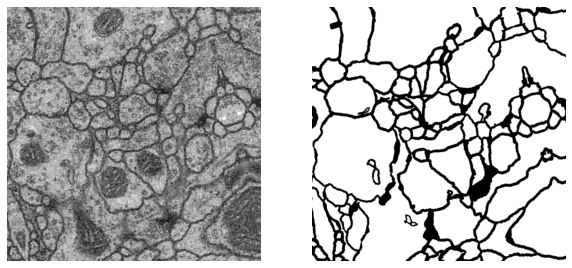

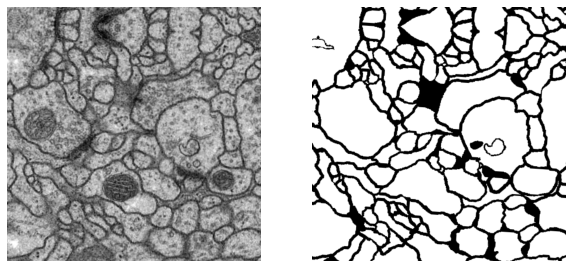

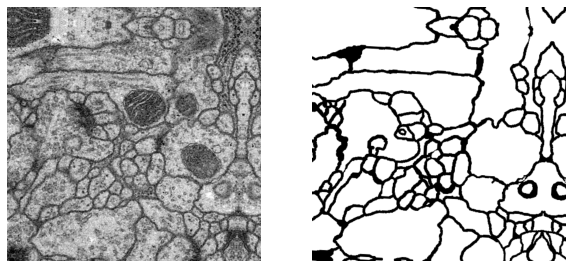

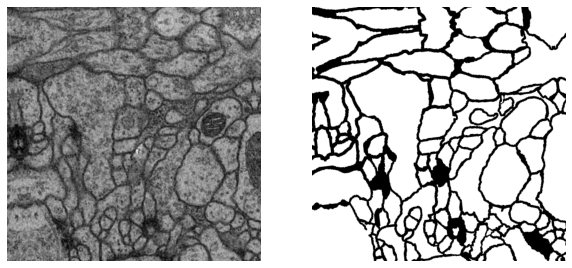

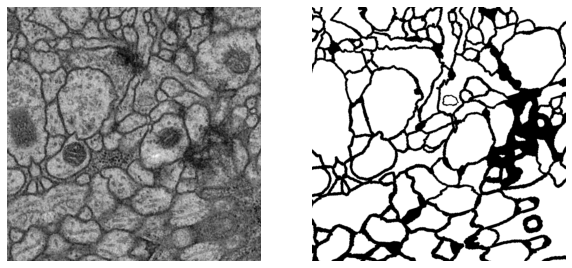

In [7]:
# show augmentated images
def show_aug_image(ncols, image_generator, mask_generator):
    for i in range(ncols):
        img = image_generator.next()
        msk = mask_generator.next()
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(img[0], cmap='gray')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(msk[0], cmap='gray')
        plt.axis('off')
        plt.show()
    
show_aug_image(5, image_train_generator, mask_train_generator)

### Build U-Net model

In [8]:
def unet(n_filters, input_shape=(512,512,1)):
    ## input layer
    inputs = Input(shape=input_shape)
############################## Contracting Path ##############################
    ## first down-sampling
    c1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    ## second down-sampling
    c2 = Conv2D(n_filters*2, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(n_filters*2, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    ## third down-sampling
    c3 = Conv2D(n_filters*4, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(n_filters*4, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    ## fourth down-sampling
    c4 = Conv2D(n_filters*8, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(n_filters*8, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
############################################################################
    ## fifth down-sampling
    c5 = Conv2D(n_filters*16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(n_filters*16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c5)
    c5 = BatchNormalization()(c5)
############################################################################

############################## Expansive Path ##############################
    ## first up-sampling
    u6 = Conv2DTranspose(n_filters*4, (2,2), strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(n_filters*8, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(n_filters*8, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c6)
    c6 = BatchNormalization()(c6)
    ## second up-sampling
    u7 = Conv2DTranspose(n_filters*2, (2,2), strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(n_filters*4, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(n_filters*4, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c7)
    c7 = BatchNormalization()(c7)
    ## third up-sampling
    u8 = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(n_filters*2, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(n_filters*2, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c8)
    c8 = BatchNormalization()(c8)
    ## fourth up-sampling
    u9 = Conv2DTranspose(n_filters//2, (2,2), strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c9)
    c9 = BatchNormalization()(c9)
    
    ## output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    ## define model
    unet = Model(inputs=[inputs], outputs=[outputs])
    return unet

In [9]:
model = unet(n_filters=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### model compile and set early stopping

In [10]:
# model compile
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [11]:
EPOCH = 100

history = model.fit_generator(train_generator,
                              steps_per_epoch=12,
                              validation_data=valid_generator,
                              validation_steps=3,
                              epochs=EPOCH,
                              callbacks=[earlystop])

Epoch 1/100
12/12 [==============================] - 13s 700ms/step - loss: 0.6660 - accuracy: 0.6146 - val_loss: 0.8825 - val_accuracy: 0.1815
Epoch 2/100
12/12 [==============================] - 4s 328ms/step - loss: 0.6036 - accuracy: 0.6903 - val_loss: 0.7032 - val_accuracy: 0.4289
Epoch 3/100
12/12 [==============================] - 4s 331ms/step - loss: 0.5616 - accuracy: 0.7209 - val_loss: 0.6392 - val_accuracy: 0.7040
Epoch 4/100
12/12 [==============================] - 4s 329ms/step - loss: 0.5138 - accuracy: 0.7538 - val_loss: 0.5990 - val_accuracy: 0.7262
Epoch 5/100
12/12 [==============================] - 4s 330ms/step - loss: 0.4697 - accuracy: 0.7939 - val_loss: 0.5725 - val_accuracy: 0.7269
Epoch 6/100
12/12 [==============================] - 4s 329ms/step - loss: 0.4303 - accuracy: 0.8221 - val_loss: 0.5484 - val_accuracy: 0.7312
Epoch 7/100
12/12 [==============================] - 4s 329ms/step - loss: 0.4095 - accuracy: 0.8361 - val_loss: 0.5389 - val_accuracy: 0.729

Epoch 58/100
12/12 [==============================] - 4s 331ms/step - loss: 0.2371 - accuracy: 0.8787 - val_loss: 0.3427 - val_accuracy: 0.8603
Epoch 59/100
12/12 [==============================] - 4s 329ms/step - loss: 0.2352 - accuracy: 0.8790 - val_loss: 0.3098 - val_accuracy: 0.8639
Epoch 00059: early stopping


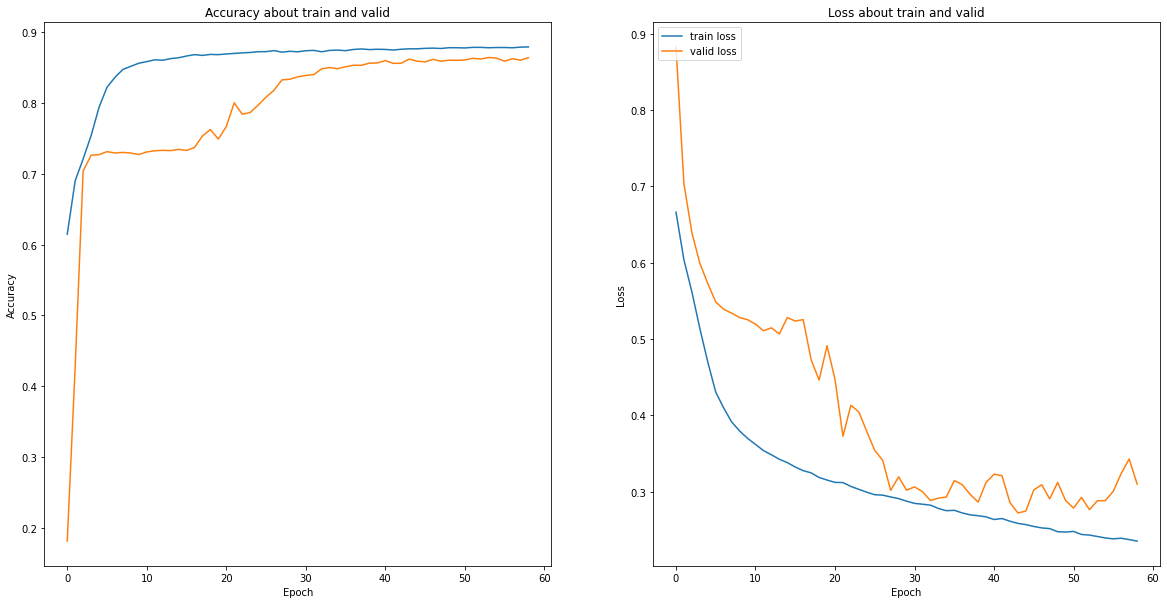

In [24]:
# show loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Accuracy about train and valid')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0,1)
plt.subplot(1,2,2)
plt.title('Loss about train and valid')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0,2)
plt.legend(loc='upper left')
plt.show()

### check performance of model

In [25]:
def load_data(path):
    os.chdir(path)
    files = os.listdir(path)
    data = []
    for file in files:
        f = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        data.append(f/255.)
    return np.array(data)

test_image = load_data(r'C:\Users\user\MY_DL\unet\data\test\X_test')

In [26]:
prediction = model.predict(test_image)

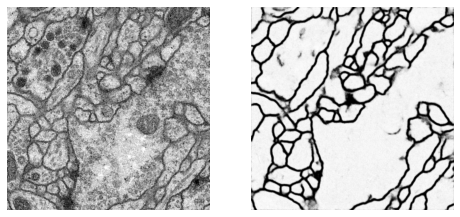

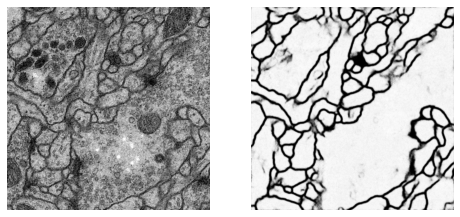

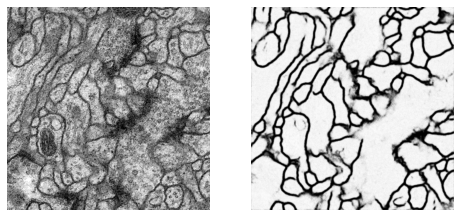

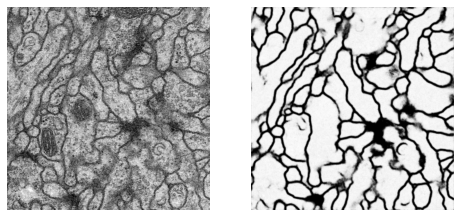

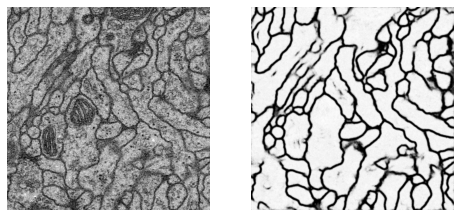

In [27]:
def show_result(ncols, image, prediction):
    for i in range(ncols):
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.imshow(image[i], cmap='gray')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(prediction[i], cmap='gray')
        plt.axis('off')
        plt.show()
        
show_result(5, test_image, prediction)